In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection, metrics
import pickle

print(pd.__version__) #1.1.3
print(sns.__version__) #0.11.0
print(matplotlib.__version__) # 3.3.2
print(sklearn.__version__) # 0.23.2

1.1.3
0.11.0
3.3.2
0.23.2


In [2]:
# récupération des données

data = pd.read_csv("data/train_resampled.csv")

cat_features = pickle.load(open("pickle_cat_features.pkl", "rb"))

X = data.drop(columns=['TARGET','Unnamed: 0'])
y = data["TARGET"]

del data
gc.collect()

0

In [3]:
# rectification des noms des features pour le classifieur LGBM

def replace_name(name):
    for c in ["[","]",",","{","}",'"',":"," "]:
        if c in name :
            name = name.replace(c,"_")
    return name
            
features = list(map(replace_name, X.columns))
X.columns = features

In [4]:
# métrique F_beta

BETA = 2

def f_beta(y_true, probas_pred):
    y_pred = np.vectorize(lambda x : 0 if x<0.5 else 1)(probas_pred)
    score = metrics.fbeta_score(y_true, y_pred, beta=BETA)
    return "F_beta", score, True

In [5]:
# séparation train et valid set

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X, y, test_size=0.2, 
                                                                      random_state=123)
del X, y
gc.collect()

60

In [6]:
# entaînement du modèle

clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,
        learning_rate=0.01604238736764179,
        num_leaves=39,
        colsample_bytree=0.18704675203879897,
        subsample=0.9261485670593478,
        max_depth=6,
        reg_alpha=0.8470633083206642,
        reg_lambda=0.5740182739981458,
        min_split_gain=0.0848793956471949,
        min_child_weight=31.190087127061712,
        silent=-1,
        verbose=-1,
        random_state=123,
        categorical_feature=list(np.where(train_x.columns.isin(cat_features))[0]))

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
    eval_metric=f_beta, verbose= 200, early_stopping_rounds= 200)

/home/samuel/.local/lib/python3.8/site-packages/lightgbm/basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.270954	training's F_beta: 0.89569	valid_1's binary_logloss: 0.271072	valid_1's F_beta: 0.895489
[400]	training's binary_logloss: 0.199977	training's F_beta: 0.901876	valid_1's binary_logloss: 0.201086	valid_1's F_beta: 0.901016
[600]	training's binary_logloss: 0.176879	training's F_beta: 0.905872	valid_1's binary_logloss: 0.179937	valid_1's F_beta: 0.904598
[800]	training's binary_logloss: 0.166475	training's F_beta: 0.908958	valid_1's binary_logloss: 0.171773	valid_1's F_beta: 0.90661
[1000]	training's binary_logloss: 0.159677	training's F_beta: 0.911061	valid_1's binary_logloss: 0.167258	valid_1's F_beta: 0.907764
[1200]	training's binary_logloss: 0.154706	training's F_beta: 0.913004	valid_1's binary_logloss: 0.164747	valid_1's F_beta: 0.908803
[1400]	training's binary_logloss: 0.150613	training's F_beta: 0.914407	valid_1's binary_logloss: 0.162959	valid_1's F_beta: 0.90957
[1600]	trainin

LGBMClassifier(categorical_feature=[0, 1, 2, 3, 9, 10, 11, 12, 13, 20, 21, 22,
                                    23, 24, 25, 26, 30, 38, 84, 85, 87, 88, 94,
                                    95, 96, 97, 98, 99, 100, 101, ...],
               colsample_bytree=0.18704675203879897,
               learning_rate=0.01604238736764179, max_depth=6,
               min_child_weight=31.190087127061712,
               min_split_gain=0.0848793956471949, n_estimators=10000,
               num_leaves=39, random_state=123, reg_alpha=0.8470633083206642,
               reg_lambda=0.5740182739981458, silent=-1,
               subsample=0.9261485670593478, verbose=-1)

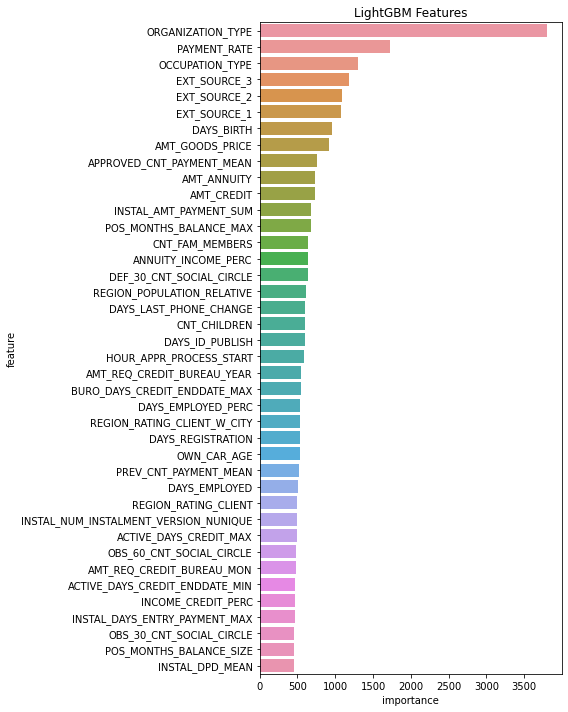

In [7]:
# features importances

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = train_x.columns
feature_importance_df["importance"] = clf.feature_importances_
best_features_idx = feature_importance_df.sort_values(by="importance", ascending=False)[:40].index
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=feature_importance_df.iloc[best_features_idx].sort_values(by="importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('img/lgbm_importances02.png')

In [8]:
# enregistrement du modèle
pickle.dump(clf, open("pickle_lgbm_classifier.pkl", "wb"))